# Flower image classification using Computer Vision






In [1]:
import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd

import random
random.seed(32)

import glob
import h5py

import os
from os import listdir

import json
import datetime
import time
from tqdm import tqdm

#Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#image handling libraries
import cv2
import scipy
import scipy.io
from scipy import ndimage

#skimage library imports
from skimage import io, filters, morphology, measure
from skimage.measure import label,  regionprops
from skimage.filters import sobel

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

import pickle

# keras imports
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model, load_model, model_from_json
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D
from keras.layers.merge import add
from keras.utils import plot_model, to_categorical
from keras.callbacks import ModelCheckpoint


#Diagnostic libraries
from nltk.translate.bleu_score import corpus_bleu

c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\programdata\anaconda3\env

In [2]:
folderName = r'../Storage/102flowers'
imageDir = folderName + '/jpg'

In [3]:
#Get the image path from the respective directories along with image names
def get_image(directory) :
    data_dic = {}
    images = []
        
    for name in listdir(directory): 
        filename = directory + '/' + name
        images.append(filename)
        data_dic.setdefault(directory[-1], images)
    
    return data_dic

In [4]:
#data_dictionary is the dictionary created which contains image location vs list of image names with full path
dataset_directory = imageDir
data_dictionary = get_image(dataset_directory)

In [5]:
#imagelabels.mat contains labels of the images and number of images for each label
#labels and unique are the lists that contain the label ids and respective number of images 
mat = scipy.io.loadmat('imagelabels.mat')
labels = mat['labels'].tolist()
unique, counts = np.unique(labels, return_counts=True)

In [6]:
#Print the contents of unique ids and the number of images per image id
print("Image Unique Ids :", unique)
print()
print("Number of Imagea per id :", counts)
print()
#Print the total number of images from Oxford 102 category image database
print("Total Number of images ", len(labels[0]))

Image Unique Ids : [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102]

Number of Imagea per id : [ 40  60  40  56  65  45  40  85  46  45  87  87  49  48  49  41  85  82
  49  56  40  59  91  42  41  41  40  66  78  85  52  45  46  40  43  75
 108  56  41  67 127  59 130  93  40 196  67  71  49  92 258  85  93  61
  71 109  67 114  67 109  50  55  54  52 102  61  42  54  54  62  78  96
 194 171 120 107 251 137  41 105 166 112 131  86  63  58  63 154 184  82
  76  66  46 162 128  91  66  82  63  49  58  48]

Total Number of images  8189


In [7]:
#Example of Label for Lotus flower that contains 177 images
print("Image id for Lotus", labels[0][0])
print("Number of lotus images", counts[101])

#Print Label id for the image name 
image_name_id = '07189'
image_name_id_int = int(image_name_id)
print("Unique id {0} for the image name id {1}".format(labels[0][image_name_id_int], image_name_id))

Image id for Lotus 77
Number of lotus images 48
Unique id 6 for the image name id 07189


In [8]:
#find a flower label from flower image name
def find_flower_label_from_flower_image_name(flower_image_name):
    flower_id = flower_image_name.split('_')[1].split('.')[0]
    flower_id_int = int(flower_id)
    return labels[0][flower_id_int - 1]

In [9]:
#Find the start index of the image label from the image label list
def find_unique_label(label_to_find):
    index = 0
    for label in labels:
        for lbl in label:
            index = index + 1
            #print("index1, label", index, lbl)
            if lbl == label_to_find:
                #print("index2", index)
                return index
    return index

In [10]:
#Test for finding start index for a particular label for lotus flower 
print("Find the start index of label for lotus flower: ", find_unique_label(78))

print("Find the flower image label for a particular image name", find_flower_label_from_flower_image_name('image_04563.jpg'))

Find the start index of label for lotus flower:  1827
Find the flower image label for a particular image name 40


In [21]:
print("Find the flower image label for a particular image name", find_flower_label_from_flower_image_name('image_06519.jpg'))

Find the flower image label for a particular image name 26


In [12]:
#oxford102_flower_dataset_labels.txt contains a dataset where index is the unique label and column "Names" is the name of the flower for the image label id 
#read labels from oxford102_flower_dataset_labels.txt
oxford102_labels = pd.read_csv('oxford102_flower_dataset_labels.txt', delimiter='\t', header=None, names=['Names'])
# Image labels are 1 based, changed the index of the image database label
oxford102_labels.index = np.arange(1, len(oxford102_labels) + 1)
print(oxford102_labels)
print()
print("Test Print: FLower Name and its unique label")
print(oxford102_labels.loc[77])

                            Names
1                 'pink primrose'
2     'hard-leaved pocket orchid'
3              'canterbury bells'
4                     'sweet pea'
5              'english marigold'
..                            ...
98              'mexican petunia'
99                     'bromelia'
100              'blanket flower'
101             'trumpet creeper'
102             'blackberry lily'

[102 rows x 1 columns]

Test Print: FLower Name and its unique label
Names     'passion flower'
Name: 77, dtype: object


In [20]:
print(oxford102_labels.Names['alpine sea holly'])

KeyError: 'alpine sea holly'

In [13]:
#Find the name of the flower from the image name from the image database
def find_flower_category_name(file_path):
    flower_name = file_path.split("\\")[-1]
    flower_label = find_flower_label_from_flower_image_name(flower_name)
    flower_category_name = oxford102_labels.loc[flower_label]
    return eval(flower_category_name[0]).strip()

print("Test Print: for Image name image_00993.jpg, flower name is ", find_flower_category_name('/content/drive/My Drive/App/Storage/102flowers/jpg/image_00993.jpg'))

Test Print: for Image name image_00993.jpg, flower name is  wallflower


In [14]:
#Extract image number from the image name of the image database
def get_flower_id(file_path):
    return file_path.split('\\')[-1].split('.')[0].split('_')[1]

print("Test Print: Get the flower image number from the image database ", get_flower_id('/content/drive/My Drive/App/Storage/102flowers/jpg/image_00993.jpg'))

Test Print: Get the flower image number from the image database  00993


In [14]:
#Create the image database dictionary which contains flower number of the image database vs flower name
#data dictionary must be flower id vs tuple (flower category name, flower path)
#flower id is in the flower name we need to extract it from the flower image name
#actual flower name is in oxford102_labels data frame

def get_image_dictionary(filepath) :
    data_dic = {}
    for directory in glob.glob(filepath):
                
        for file in glob.glob(directory + '/image_*.jpg'):
            flower_id = get_flower_id(file)
            flower_category_name = find_flower_category_name(file)
            image = (flower_category_name, file)
            data_dic[flower_id] = image 
    
    return data_dic

In [15]:
#image_database will be used throughout this project for getting all the flower information from the image database 
image_database = get_image_dictionary(dataset_directory)

In [16]:
# Save image database for offline usage and saving time for re executing the above
pickle_out = open(folderName + "/" + "dict.image_database.pickle","wb")
pickle.dump(image_database, pickle_out)
pickle_out.close()

In [17]:
#Test print of the content of the image_databse
for x, y in image_database.items():
  print(x, y)
  break

07335 ('foxglove', '../Storage/102flowers/jpg\\image_07335.jpg')


In [18]:
#Creating a catalogue for number of training and testing images for each category of flower label
#decided to have 80% traing images per category and 20% test images per category.
#The train_test_category creates a dictionary which contains number of training and testing images for each category under the above decision
def get_train_test_catalog(counts, factor):
    train_test_catalog = {}
    for uc in range(102):
        train_data_count = int(counts[uc] * factor)
        test_data_count = counts[uc] - train_data_count
        train_test_catalog[unique[uc]] = (train_data_count, test_data_count)
    
    return train_test_catalog

In [19]:
#train_test_catalog variable will be used throughout this project for getting number of training and testing images for each category of image label
train_test_catalog = get_train_test_catalog(counts, 0.8)

print("Test Print: Train Test image numbers per category of images with their image label ids")
print(train_test_catalog)

Test Print: Train Test image numbers per category of images with their image label ids
{1: (32, 8), 2: (48, 12), 3: (32, 8), 4: (44, 12), 5: (52, 13), 6: (36, 9), 7: (32, 8), 8: (68, 17), 9: (36, 10), 10: (36, 9), 11: (69, 18), 12: (69, 18), 13: (39, 10), 14: (38, 10), 15: (39, 10), 16: (32, 9), 17: (68, 17), 18: (65, 17), 19: (39, 10), 20: (44, 12), 21: (32, 8), 22: (47, 12), 23: (72, 19), 24: (33, 9), 25: (32, 9), 26: (32, 9), 27: (32, 8), 28: (52, 14), 29: (62, 16), 30: (68, 17), 31: (41, 11), 32: (36, 9), 33: (36, 10), 34: (32, 8), 35: (34, 9), 36: (60, 15), 37: (86, 22), 38: (44, 12), 39: (32, 9), 40: (53, 14), 41: (101, 26), 42: (47, 12), 43: (104, 26), 44: (74, 19), 45: (32, 8), 46: (156, 40), 47: (53, 14), 48: (56, 15), 49: (39, 10), 50: (73, 19), 51: (206, 52), 52: (68, 17), 53: (74, 19), 54: (48, 13), 55: (56, 15), 56: (87, 22), 57: (53, 14), 58: (91, 23), 59: (53, 14), 60: (87, 22), 61: (40, 10), 62: (44, 11), 63: (43, 11), 64: (41, 11), 65: (81, 21), 66: (48, 13), 67: (33, 

In [20]:
#Converting any number in the format of image name that is shown in the image database
def convert_to_img_ids(random_digits):
    ret_img_ids = []
    list_digits = iter(random_digits)
    for digit in list_digits:
        
        length = len(str(digit))
        id = ''
        for i in range(5-length):
            id = id + "0"
        id = id + str(digit)
        ret_img_ids.append(id)
    return ret_img_ids

print("Test Print: a list of numbers to be converted to image name id formats")
print(convert_to_img_ids([1, 2, 3, 4, 5]))

Test Print: a list of numbers to be converted to image name id formats
['00001', '00002', '00003', '00004', '00005']


In [21]:
#Generate training and testing image name ids under each category (label) whoose count has been decided by train_test_catalog
def generate_train_test_split():
    start_range = 1
    end_range = 0

    train_test_catalog = get_train_test_catalog(counts, 0.8)
    zipped = zip(counts, train_test_catalog.items())

    list_train_test_random_index = []
    for count, (index , train_test_count) in zipped:
        
        if start_range == 1:
            end_range = count
        else:
            end_range = start_range + count
        r = random.sample(range(start_range, end_range), count - 1)
        start_range = end_range
        train_random_digits = r[:train_test_count[0]]
        test_random_digits = r[train_test_count[0] :]
        
        train_img_ids = convert_to_img_ids(train_random_digits)
        test_img_ids = convert_to_img_ids(test_random_digits)
        list_train_test_random_index.append((train_img_ids, test_img_ids))

    return list_train_test_random_index

In [22]:
#train_test_split_img_numbers will be used throughtout this project for the exact image numbers from the image database that will be used either for training or testing purposes
train_test_split_img_numbers = generate_train_test_split()

In [23]:
#List of training image names and testing image names based on the above categorization
def train_test_img_nums():
  train = []
  test = []
  
  for tr, te in train_test_split_img_numbers:
    train.extend(tr)
    test.extend(te)

  return train, test

In [24]:
#train_img_nums, test_img_nums will be used throughout this project when training or testing the model
train_img_nums, test_img_nums = train_test_img_nums()

In [25]:
#converting the image_database into train and test datasets
#using 80:20 principles for each category the images will be separated in that ratio for traning and test purposes.
def load_image_data(img_nums, image_size):
    
    testing_img_data = {}
    
    for test_img_num in img_nums:
        
      if test_img_num in image_database:
        #example 00001 ('pink primrose', 'C:\\Users\\indra\\Learning\\Upgrad\\LJMU\\
        #FlowerClassificationOxford102CategoryImages\\102flowers\\jpg\\image_00001.jpg')
        img_data = image_database[test_img_num]
        image = cv2.imread(img_data[1],cv2.IMREAD_COLOR)
        image = cv2.resize(image, (image_size,image_size))
        testing_img_data[test_img_num] = image
                
    return testing_img_data 

In [26]:
#training_img_data will be used throught the project
training_img_data = load_image_data(train_img_nums, 256)

In [27]:
#Total number of training images
print("Total number of training images ", len(train_img_nums))

Total number of training images  6507


In [28]:
pickle_out = open(folderName + "/" + "dict.training_img_data.pickle","wb")
pickle.dump(training_img_data, pickle_out)
pickle_out.close()

In [29]:
#testing_img_data will be used throught the project
testing_img_data = load_image_data(test_img_nums, 256)

In [30]:
pickle_out = open(folderName + "/" + "dict.testing_img_data.pickle","wb")
pickle.dump(testing_img_data, pickle_out)
pickle_out.close()

In [31]:
#Convert RGB to Gray image
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [32]:
#Create Masked images using KNN, will be used for Petals count calculation
def CreateMaskedImageUsingKNN(training_img_data_set):
    
    dic_masked_img = {}
    
    for key, img in tqdm(training_img_data_set.items()) :
        pic = img/255  # dividing by 255 to bring the pixel values between 0 and 1

        pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
    
        kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
        pic2show = kmeans.cluster_centers_[kmeans.labels_]
        cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
        gray = rgb2gray(cluster_pic)
        
        gray_reshaped = gray.reshape(gray.shape[0], gray.shape[1], 1)
        
        dic_masked_img[key] = gray_reshaped
    
    return dic_masked_img

In [33]:
#Load training_img_data
pickle_in = open(folderName + "/" + "dict.training_img_data.pickle","rb")
training_img_data = pickle.load(pickle_in)

In [34]:
#Stopwatch to understand consumed time for any operation
def stopwatch(value):
    '''From seconds to Days;Hours:Minutes;Seconds'''

    valueD = (((value/365)/24)/60)
    Days = int (valueD)

    valueH = (valueD-Days)*365
    Hours = int(valueH)

    valueM = (valueH - Hours)*24
    Minutes = int(valueM)

    valueS = (valueM - Minutes)*60
    Seconds = int(valueS)
    print("Days: {0}, Hours: {1}, Minutes: {2}, Seconds: {3}".format(Days, Hours, Minutes, Seconds))

In [43]:
start = time.time()
masked_img_dataset_dictionary = CreateMaskedImageUsingKNN(training_img_data)
end = time.time()
print("Time taken:")
stopwatch(end-start)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5317/5317 [24:31<00:00,  3.61it/s]

Time taken:
Days: 0, Hours: 1, Minutes: 0, Seconds: 31


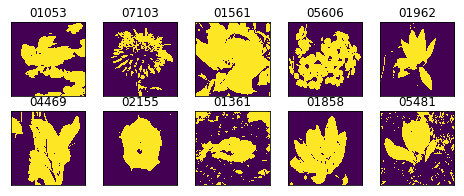

In [45]:
#Print Masked Images after applying KNN
fig = plt.figure(figsize=(8,3))
for i, (key, img_masked) in zip(range(10), masked_img_dataset_dictionary.items()):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(key)
    img_masked = img_masked.reshape(img_masked.shape[0], img_masked.shape[1])
    plt.imshow(img_masked)
plt.show()

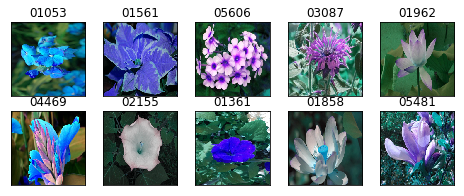

In [46]:
#Print Original images for the above
fig = plt.figure(figsize=(8,3))
for i, (key, img_training) in zip(range(10), training_img_data.items()):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(key)
    plt.imshow(img_training)
plt.show()

### Find Count of petals

**Attempt # 1**

In [47]:
image_size = 256

(256, 256)


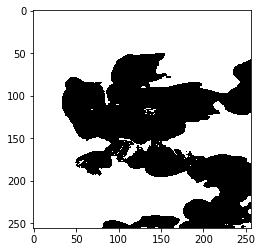

39
Petal Counts:  5


In [48]:
#Attempt 1 using otsu algorithm for petal count
for (key, img_masked) in masked_img_dataset_dictionary.items():
  
  im = np.reshape(img_masked*255, (image_size, image_size))
  val = filters.threshold_otsu(im)
  drops = ndimage.binary_fill_holes(im < val)
  print(drops.shape)
  plt.imshow(drops, cmap='gray')
  plt.show()
  
  
  label_image = measure.label(drops)
  print(label_image.max())
  
  count = 0
  for region in regionprops(label_image):
    
    if region.area > 40 :
      count = count + 1
  
  print("Petal Counts: ", count)
  break

Petal count was not successful for all the images from the training image dataset


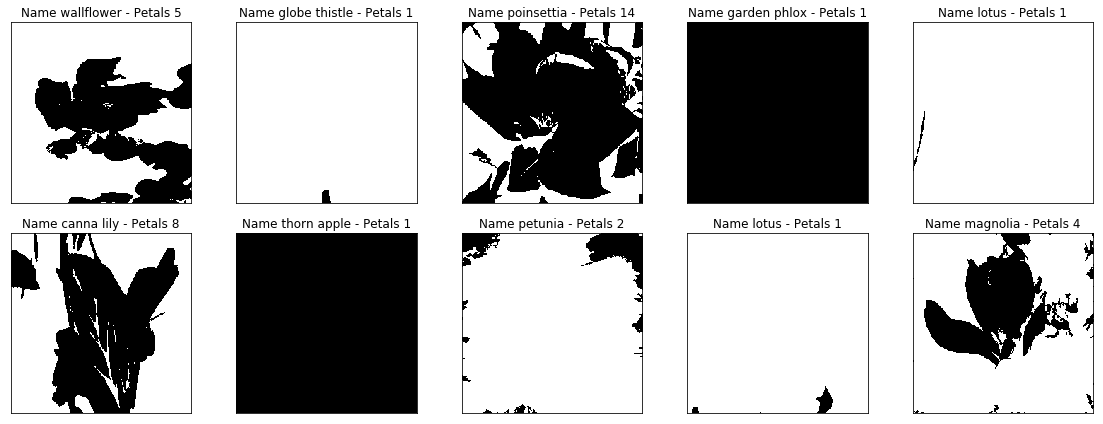

In [49]:
print("Petal count was not successful for all the images from the training image dataset")
fig = plt.figure(figsize=(16,6))
for i, (key, img_masked) in zip(range(10), masked_img_dataset_dictionary.items()):
  
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    
    #fill image holes
    im = np.reshape(img_masked*255, (image_size, image_size))
    val = filters.threshold_otsu(im)
    drops = ndimage.binary_fill_holes(im < val)
    
    #find petals count
    label_image = measure.label(drops)
    count = 0
    for region in regionprops(label_image):
      if region.area > 40 :
        count = count + 1
    
    image_key = "Name {} - Petals {}"
    name = image_database[key][0]
    ax.set_title(image_key.format(name, count))
    plt.tight_layout()
    plt.imshow(drops, cmap='gray')
    
plt.show()

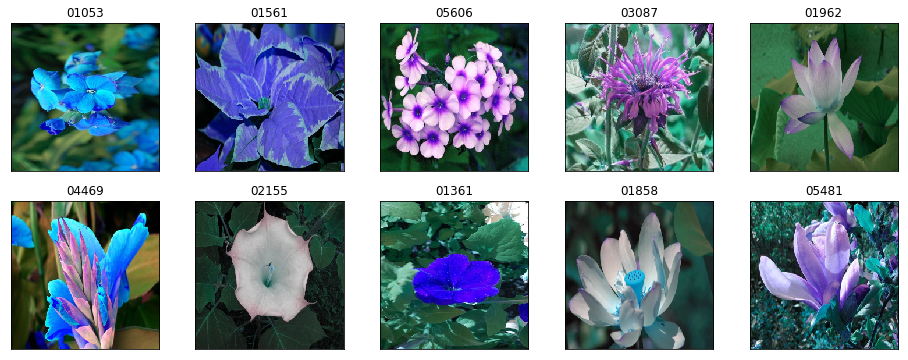

In [50]:
#Displaying the original images for which Petals count is tried
fig = plt.figure(figsize=(16,6))
for i, (key, img_training) in zip(range(10), training_img_data.items()):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(key)
    plt.imshow(img_training)
plt.show()

**Attempt # 2**

Using Region Based and Watershed transform

Petal Counts:  0


c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\matplotlib\axes\_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


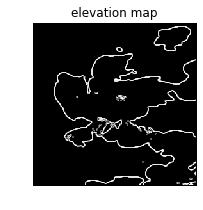

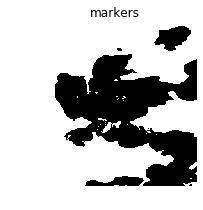

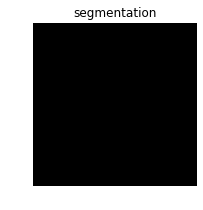

In [51]:
for (key, img_masked) in masked_img_dataset_dictionary.items():
  
  im = np.reshape(img_masked*255, (image_size, image_size))
  
  # find an elevation map using the Sobel gradient of the image.
  elevation_map = sobel(im)
    
  fig, ax = plt.subplots(figsize=(4, 3))
  ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
  ax.set_title('elevation map')
  ax.axis('off')
  ax.set_adjustable('box-forced')
  
  # find markers of the background and the petals based on the extreme parts of the histogram of grey values
  markers = np.zeros_like(im)
  markers[im < 90] = 1
  markers[im > 150] = 2

  fig, ax = plt.subplots(figsize=(4, 3))
  ax.imshow(markers, cmap=plt.cm.gray, interpolation='nearest')
  ax.set_title('markers')
  ax.axis('off')
  ax.set_adjustable('box-forced')
  
  #use the watershed transform to fill regions of the elevation map starting from the markers determined above
  segmentation = morphology.watershed(elevation_map, markers)

  fig, ax = plt.subplots(figsize=(4, 3))
  ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
  ax.set_title('segmentation')
  ax.axis('off')
  ax.set_adjustable('box-forced')
  
  
  segmentation = ndimage.binary_fill_holes(segmentation - 1)
  labeled_image, _ = ndimage.label(segmentation)
  
  count = 0
  for region in regionprops(labeled_image):
    
    if region.area > 40 :
      count = count + 1
  
  print("Petal Counts: ", count)
  break

###To Do
###1. Get the petals for each of the flower classes
###2. Create a new dataframe from oxford102_labels where columns are "Name" and "Petals". This will be used when prediction of the flowers is done.
###3. Then use a model to identify a flower and use this dataframe for the output of the flower predicted.


In [52]:
def get_petals_count_using_region_based_watershed_transform(image):
  # find an elevation map using the Sobel gradient of the image.
  elevation_map = sobel(im)
    
  # find markers of the background and the petals based on the extreme parts of the histogram of grey values
  markers = np.zeros_like(im)
  markers[im < 90] = 1
  markers[im > 150] = 2

 
  #use the watershed transform to fill regions of the elevation map starting from the markers determined above
  segmentation = morphology.watershed(elevation_map, markers)

  segmentation = ndimage.binary_fill_holes(segmentation - 1)
  labeled_image, _ = ndimage.label(segmentation)
  
  count = 0
  for region in regionprops(labeled_image):
    
    if region.area > 40 :
      count = count + 1
  
  return count

In [53]:
predicted_petals_from_masked_imgs = {}
for (key, img_masked) in tqdm(masked_img_dataset_dictionary.items()):
  
  im = np.reshape(img_masked*255, (image_size, image_size))
  count = get_petals_count_using_region_based_watershed_transform(im)
  
  if key in predicted_petals_from_masked_imgs:
    list_predicted_petals = predicted_petals_from_masked_imgs[key]
    list_predicted_petals.append(count)
    predicted_petals_from_masked_imgs[key] = list_predicted_petals
  else:
    list_predicted_petals = []
    list_predicted_petals.append(count)
    predicted_petals_from_masked_imgs[key] = list_predicted_petals    

100%|████████████████████████████████████████████████████████████████████████████████████████| 5317/5317 [01:36<00:00, 54.96it/s]


### Assumptions
###1. If there is no definit number petals for a flower, then the petal count may or may not be added to the oxford102lables dictionary.
###2. The predicted petals count may or may not be displayed based on input from the user.

##Extract Features using model for image classification with weights trained on ImageNet

In [54]:
# config variables
model_name    = "resnet50" #"vgg16"  #"inceptionv3"
weights       = "imagenet"
include_top   = False #input shape will be specified, so it is false 
features_path = "output/flowers_102/inceptionv3/features.h5"
labels_path   = "output/flowers_102/inceptionv3/labels.h5"
test_size     = 0.02 #80% training data and 20% test data
results       = "output/flowers_102/inceptionv3/results.txt"
model_path    = "output/flowers_102/inceptionv3/model"
num_classes   = 102
image_size = (224, 224)

In [55]:
# create the pretrained models
# check for pretrained weight usage or not
# check for top layers to be included or not
if model_name == "vgg16":
  base_model = VGG16(weights=weights)
  #base_model.summary()
  #model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
  image_size = (224, 224)
elif model_name == "vgg19":
  base_model = VGG19(weights=weights)
  model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
  image_size = (224, 224)
elif model_name == "resnet50":
  base_model = ResNet50(weights=weights)
  #base_model.summary()
  # add a global spatial average pooling layer
  x = base_model.get_layer('avg_pool').output
  #x = GlobalAveragePooling3D()(x)
  # let's add a fully-connected layer
  #x = Dense(2048, activation='relu')(x)
  # and a logistic layer -- we have 102 classes
  #predictions = Dense(num_classes, activation='softmax')(x)
  #model = Model(input=base_model.input, output=base_model.get_layer('fc1000').output)
  model = Model(inputs=base_model.input, outputs=x)
  model.summary()
  image_size = (224, 224)
elif model_name == "inceptionv3":
  base_model = InceptionV3(include_top=include_top, weights=weights, input_tensor=Input(shape=(299,299,3)))
  base_model.summary()
  #model = Model(input=base_model.input, output=base_model.get_layer('custom').output)
  #image_size = (299, 299)
elif model_name == "inceptionresnetv2":
  base_model = InceptionResNetV2(include_top=include_top, weights=weights, input_tensor=Input(shape=(299,299,3)))
  model = Model(input=base_model.input, output=base_model.get_layer('custom').output)
  image_size = (299, 299)
elif model_name == "mobilenet":
  base_model = MobileNet(include_top=include_top, weights=weights, input_tensor=Input(shape=(224,224,3)), input_shape=(224,224,3))
  model = Model(input=base_model.input, output=base_model.get_layer('custom').output)
  image_size = (224, 224)
elif model_name == "xception":
  base_model = Xception(weights=weights)
  model = Model(input=base_model.input, output=base_model.get_layer('avg_pool').output)
  image_size = (299, 299)
else:
  base_model = None

102858752/102853048 [==============================] - 29s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [56]:
# save model and weights
model_json = model.to_json()
with open(folderName + "/" + model_path + str(test_size) + ".json", "w") as json_file:
  json_file.write(model_json)

# save weights
model.save_weights(folderName + "/" + model_path + str(test_size) + ".h5")
print("Saved model and weights to disk..")


Saved model and weights to disk..


In [57]:
# load json and create model
json_file = open(folderName + "/" + model_path + "0.02" + ".json", 'r')
loaded_pretrained_model_json = json_file.read()
json_file.close()
loaded_pretrained_model = model_from_json(loaded_pretrained_model_json)
# load weights into new model
loaded_pretrained_model.load_weights(folderName + "/" + model_path + "0.02" + ".h5")
print("Loaded pretrained model from disk")

Loaded pretrained model from disk


In [58]:
#Test Print : Training labels
train_labels = oxford102_labels.Names.tolist()
train_labels = [i.replace("'", "").strip() for i in train_labels]
print(train_labels)

['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', '"colts foot"', 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'c

In [59]:
# encode the labels
print("*******Encoding labels*******")
le = LabelEncoder()
le.fit([tl for tl in train_labels])

*******Encoding labels*******


LabelEncoder()

In [60]:
#Load image database
pickle_in = open(folderName + "/" + "dict.image_database.pickle","rb")
image_database = pickle.load(pickle_in)

### Flower Detection Using Deep Learning Model

###Create Training Features

In [61]:
pickle_in = open(folderName + "/" + "dict.image_database.pickle","rb")
image_database = pickle.load(pickle_in)

In [62]:
img_features = {}
labels_features = set()

In [63]:
for img_id in tqdm(train_img_nums):
  
  if img_id in image_database:  
    
    img_data = image_database[img_id]
    img = load_img(img_data[1], target_size=image_size)
    x = image.img_to_array(img)
    x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
    x = preprocess_input(x)
    feature = model.predict(x)
    img_features[img_id] = feature
    labels_features.add(img_data[0])
    

100%|████████████████████████████████████████████████████████████████████████████████████████| 6507/6507 [02:39<00:00, 40.90it/s]


####Save the training features

In [64]:
# save features and labels
pickle_out = open(folderName + "/" + "dict.img_features.pickle","wb")
pickle.dump(img_features, pickle_out)
pickle_out.close()

### Trial with another model for training

In [96]:

# define the captioning model
def define_model(vocab_size, max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    # modified on 9th November
    fe2 = Dense(1024, activation='relu')(fe1)
    fe3 = Dropout(0.5)(fe2)
    fe4 = Dense(512, activation='relu')(fe3)
    fe5 = Dropout(0.5)(fe4)
    fe6 = Dense(256, activation='relu')(fe5)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    #added another dropout layer on 9th nov
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe6, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    print("[inputs1, inputs2]", [inputs1, inputs2])
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    #In case of GPU the below method does not work.!!!
    #plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [66]:
#train the model

#load the features
pickle_in = open(folderName + "/" + "dict.img_features.pickle","rb")
img_features_loaded = pickle.load(pickle_in)

In [67]:
#load the features
pickle_in = open(folderName + "/" + "dict.image_database.pickle","rb")
image_database = pickle.load(pickle_in)

### Create Vocabulary for Training images

In [70]:
word_vocab = {}
for img_num in train_img_nums:
    if img_num in image_database:
        img_data = image_database[img_num]
        word_vocab[img_num] = 'startseq ' + ' '.join(str(img_num) + ' ' + img_data[0]) + ' endseq'

In [71]:
test =list()
for key, val in word_vocab.items():
  print(val)
  test.append(val)
  break

startseq 0 1 0 5 3   w a l l f l o w e r endseq


In [72]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(vocab):
    all_desc = list()
    for key, val in vocab.items():
      all_desc.append(val)
    return all_desc

In [73]:
def create_tokenizer(vocab):
    lines = to_lines(vocab)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [74]:
tokenizer = create_tokenizer(word_vocab)
print(tokenizer)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  39


In [75]:
def max_lengthTEMP(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [76]:
seq = [[150, 5, 2]]
print(seq[0][1])# seq[i]

5


In [77]:
len(word_vocab)

5317

In [78]:
vocab_size

39

In [79]:
def max_length_sentence_in_word_vocab(word_vocab):
  return max(len(i.split()) for i in word_vocab.values())

In [80]:
max_length_sentence_in_word_vocab(word_vocab)

30

###Create Vocabulary for Test images

In [82]:
test_word_vocab = {}
for img_num in test_img_nums:
    if img_num in image_database:
        img_data = image_database[img_num]
        test_word_vocab[img_num] = 'startseq ' + ' '.join(str(img_num) + ' ' + img_data[0]) + ' endseq'

In [83]:
test_tokenizer = create_tokenizer(test_word_vocab)
print(test_tokenizer)
test_vocab_size = len(test_tokenizer.word_index) + 1
print('Vocabulary Size: ', test_vocab_size)

Vocabulary Size:  39


###Extract test image features

In [84]:
test_img_features = {}
test_labels_features = set()

In [85]:
for img_id in tqdm(test_img_nums):
  
  if img_id in image_database:  
    
    img_data = image_database[img_id]
    img = load_img(img_data[1], target_size=image_size)
    x = image.img_to_array(img)
    x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
    x = preprocess_input(x)
    feature = loaded_pretrained_model.predict(x)
    test_img_features[img_id] = feature
    test_labels_features.add(img_data[0])


100%|████████████████████████████████████████████████████████████████████████████████████████| 1580/1580 [00:39<00:00, 39.69it/s]


####Save test image features

In [86]:
pickle_out = open(folderName + "/" + "dict.test_image_features.pickle","wb")
pickle.dump(test_img_features, pickle_out)
pickle_out.close()

In [87]:
#the below function loop forever with a while loop and within this, 
#loop over each image in the image directory. 
#For each image filename, we can load the image and 
#create all of the input-output sequence pairs from the image’s description.

#data generator, intended to be used in a call to model.fit_generator()
def data_generator(vocab, photos, tokenizer, max_length):
    while 1:
        for key, description_list in vocab.items():
            #retrieve photo features
            img = photos[key][0]            
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, img)
            
            X = [ input_image, input_sequence]
            yield [X, output_word]

In [88]:
#we are calling the create_sequence() function to create 
#a batch worth of data for a single photo rather than an entire dataset. 
#This means that we must update the create_sequences() function 
#to delete the “iterate over all descriptions” for-loop.            
#Updated create sequence function for data_generator
def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list.split(' '):
      # encode the sequence
      seq = tokenizer.texts_to_sequences([desc_list])[0]
      # split one sequence into multiple X,y pairs
      for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store
          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [89]:
max_length = max_lengthTEMP(word_vocab)

In [90]:
test_max_length = max_lengthTEMP(test_word_vocab)

In [97]:
epochs = 32
steps = len(word_vocab)
max_length = max_lengthTEMP(word_vocab)
print("max_length: ", max_length)

model_LSTM = define_model(vocab_size, max_length)

max_length:  30
[inputs1, inputs2] [<tf.Tensor 'input_12:0' shape=(None, 2048) dtype=float32>, <tf.Tensor 'input_13:0' shape=(None, 30) dtype=float32>]
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 2048)         0           input_12[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 1024)         2098176     dropout_21[0][0]                 
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 

In [107]:
model_LSTM = loaded_model

In [109]:
epochs = 64

In [ ]:
for i in range(epochs):
    print("Initialize Data Generator ")
    generator = data_generator(word_vocab, img_features_loaded, tokenizer, max_length)
    model_LSTM.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)
    model_LSTM.save(folderName + 'model_LSTM_' + str(i) + '.h5')
    i = i + 1

Initialize Data Generator 
Epoch 1/64
5317/5317 [==============================] - 605s 114ms/step - loss: 0.5233
Epoch 2/64
5317/5317 [==============================] - 602s 113ms/step - loss: 0.5206
Epoch 3/64
5317/5317 [==============================] - 607s 114ms/step - loss: 0.5182
Epoch 4/64
5317/5317 [==============================] - 604s 114ms/step - loss: 0.5190
Epoch 5/64
5317/5317 [==============================] - 606s 114ms/step - loss: 0.5174
Epoch 6/64
5317/5317 [==============================] - 602s 113ms/step - loss: 0.5135
Epoch 7/64
5317/5317 [==============================] - 601s 113ms/step - loss: 0.5140
Epoch 8/64
5317/5317 [==============================] - 601s 113ms/step - loss: 0.5128
Epoch 9/64
5317/5317 [==============================] - 607s 114ms/step - loss: 0.5100
Epoch 10/64
5317/5317 [==============================] - 609s 115ms/step - loss: 0.5067
Epoch 11/64
5317/5317 [==============================] - 603s 113ms/step - loss: 0.5049
Epoch 12/64
53

In [99]:
#load the latest model
model_path = folderName + 'model_LSTM_' + str(31) + '.h5'
loaded_model = load_model(model_path)

c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [100]:
pickle_in = open(folderName + "/" + "dict.testing_img_data.pickle","rb")
testing_img_data = pickle.load(pickle_in)

In [101]:
pickle_in = open(folderName + "/" + "dict.test_image_features.pickle","rb")
test_img_features = pickle.load(pickle_in)

In [102]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break

    return in_text

In [103]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [104]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc]
		actual.append(references)
		predicted.append(yhat.split())
	print('Actual:    %s' % desc)
	print('Predicted: %s' % yhat)
	# calculate BLEU score
	bleu = corpus_bleu(actual, predicted)
	return bleu

In [105]:
train_results = []
test_results = []

In [106]:
start_train_eval = time.time()
train_score = evaluate_model(loaded_model, word_vocab, img_features_loaded, tokenizer, max_length)
end_train_eval = time.time()
stopwatch(end_train_eval-start_train_eval)
start_test_eval = time.time()
test_score = evaluate_model(loaded_model, test_word_vocab, test_img_features, test_tokenizer, test_max_length)
end_test_eval = time.time()
stopwatch(end_test_eval-start_test_eval)
# store
train_results.append(train_score)
test_results.append(test_score)


Actual:    startseq 0 4 1 2 5   a r t i c h o k e endseq
Predicted: startseq 0 3 0 3 1 b e e b a l m endseq


c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it c

Days: 0, Hours: 0, Minutes: 14, Seconds: 57
Actual:    startseq 0 1 4 5 0   p e t u n i a endseq
Predicted: startseq 0 5 4 6 2 a z a l e a endseq
Days: 0, Hours: 0, Minutes: 3, Seconds: 39


In [108]:
print("The train score: {0} And test score: {1}".format(train_score, test_score))

The train score: 1.4554353610080036e-231 And test score: 1.449176985142455e-231
